N.B : The parts "Prediction "on the past"" and "Forecasting" can be skipped.

In [129]:
cd(@__DIR__)
include("table_reader.jl")
include("utils.jl")

Monthly_stats

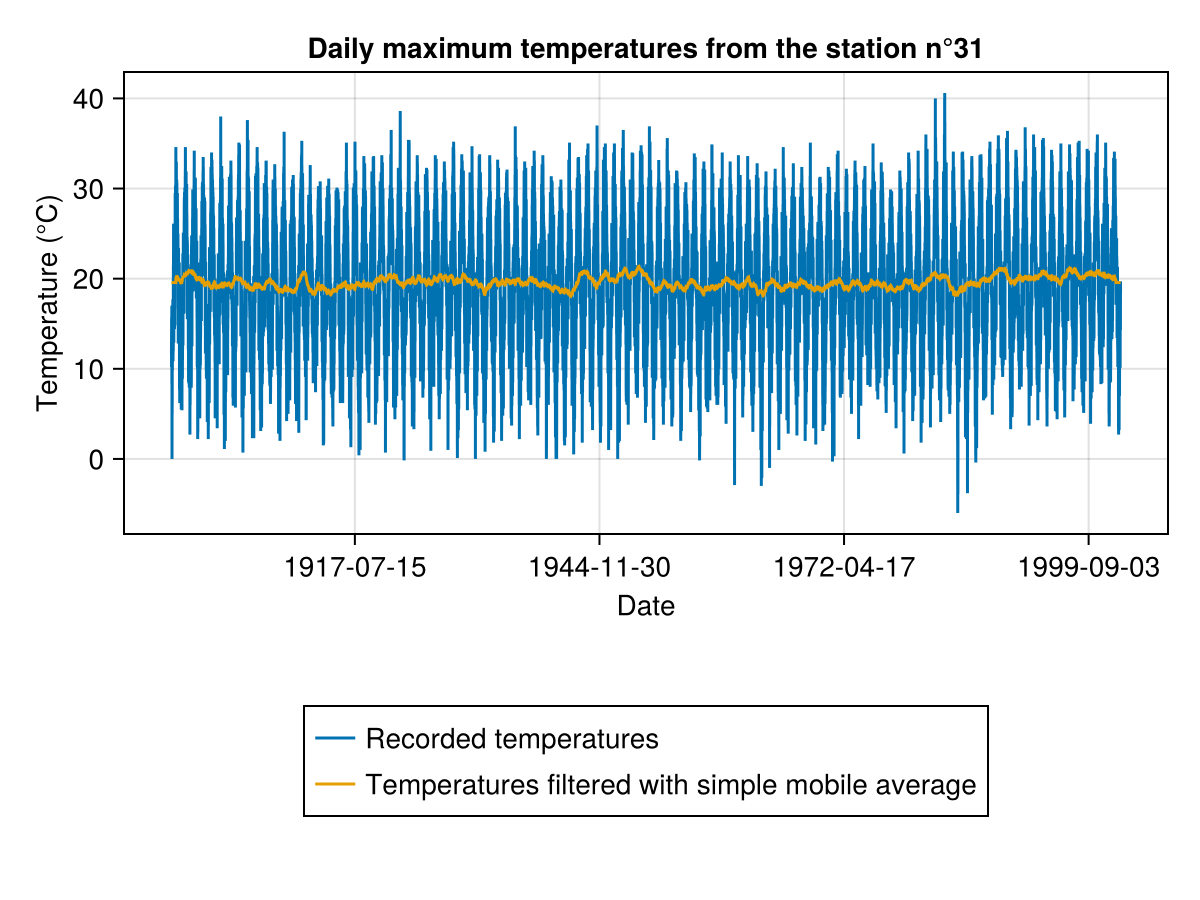

In [130]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

In [131]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

2-element Vector{Float64}:
 19.366009056392556
  1.0215034069842917e-5

There is only a constant

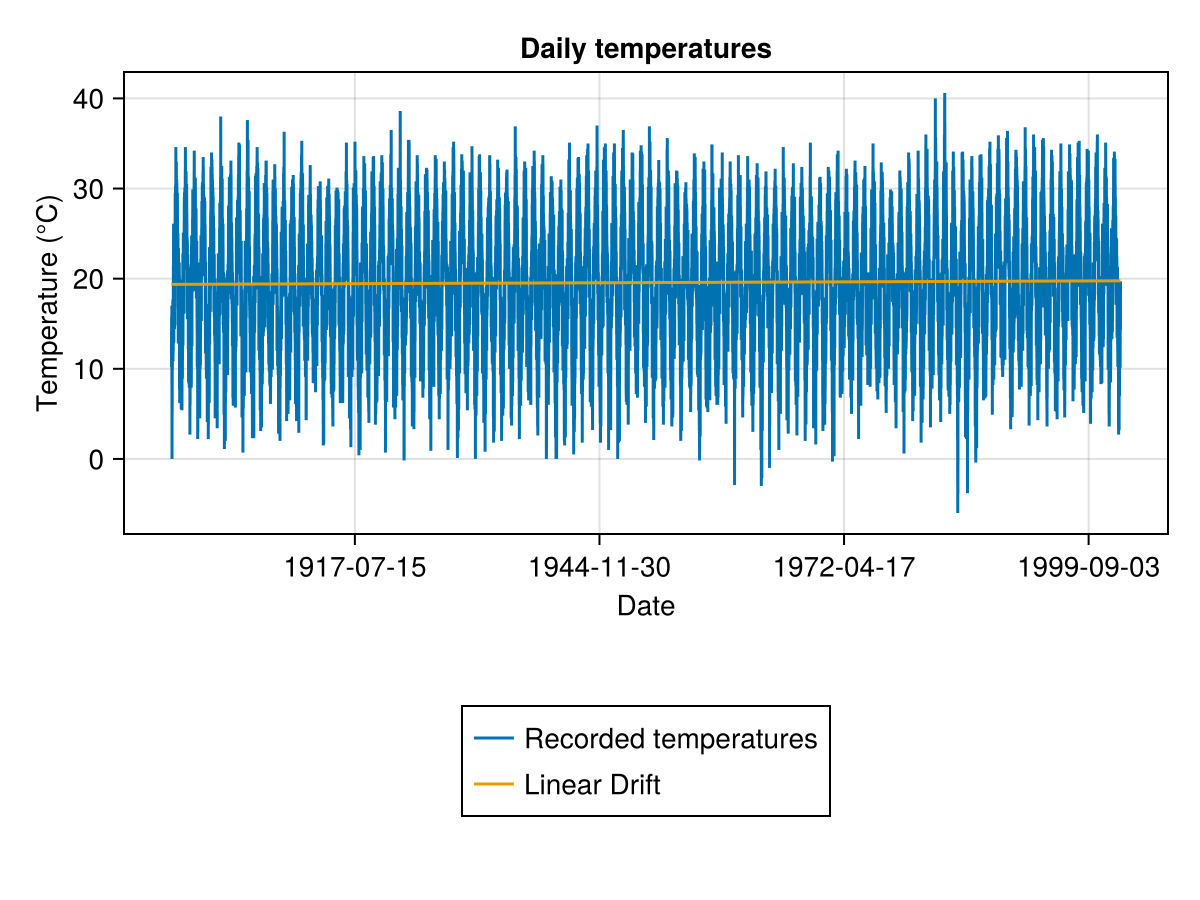

In [132]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
current_figure()

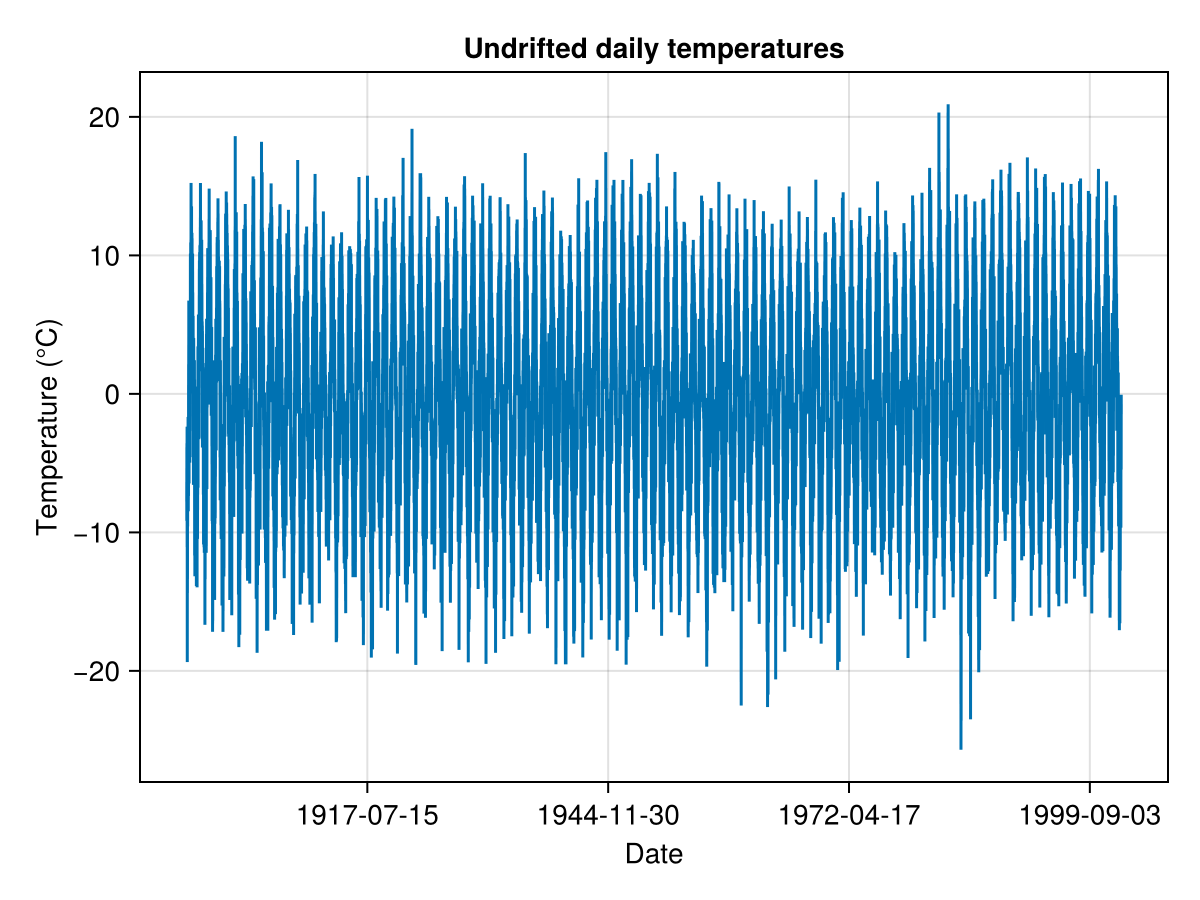

In [133]:
undrifted_series=series[!,2]-X*beta

fig, ax = lines(series.DATE, undrifted_series)
ax.title="Undrifted daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Periodicity

In [134]:
k=N ÷ 365 #k : number of years
average_period=mean(undrifted_series[i:364+i] for i in 1:365:(k-1)*365)

365-element Vector{Float64}:
 -7.840852999024626
 -7.86848226167774
 -7.472302000521335
 -7.786597929841122
 -7.358036716303765
 -7.416142169433068
 -7.493295241609997
 -7.134257837596449
 -7.360934719297186
 -7.45713541052173
  ⋮
 -8.060680027343965
 -7.8959283376161356
 -7.814986171697822
 -7.5330916248271285
 -7.524530411289771
 -8.095969197752408
 -7.9950270318341
 -7.9178943897253165
 -7.976952223807

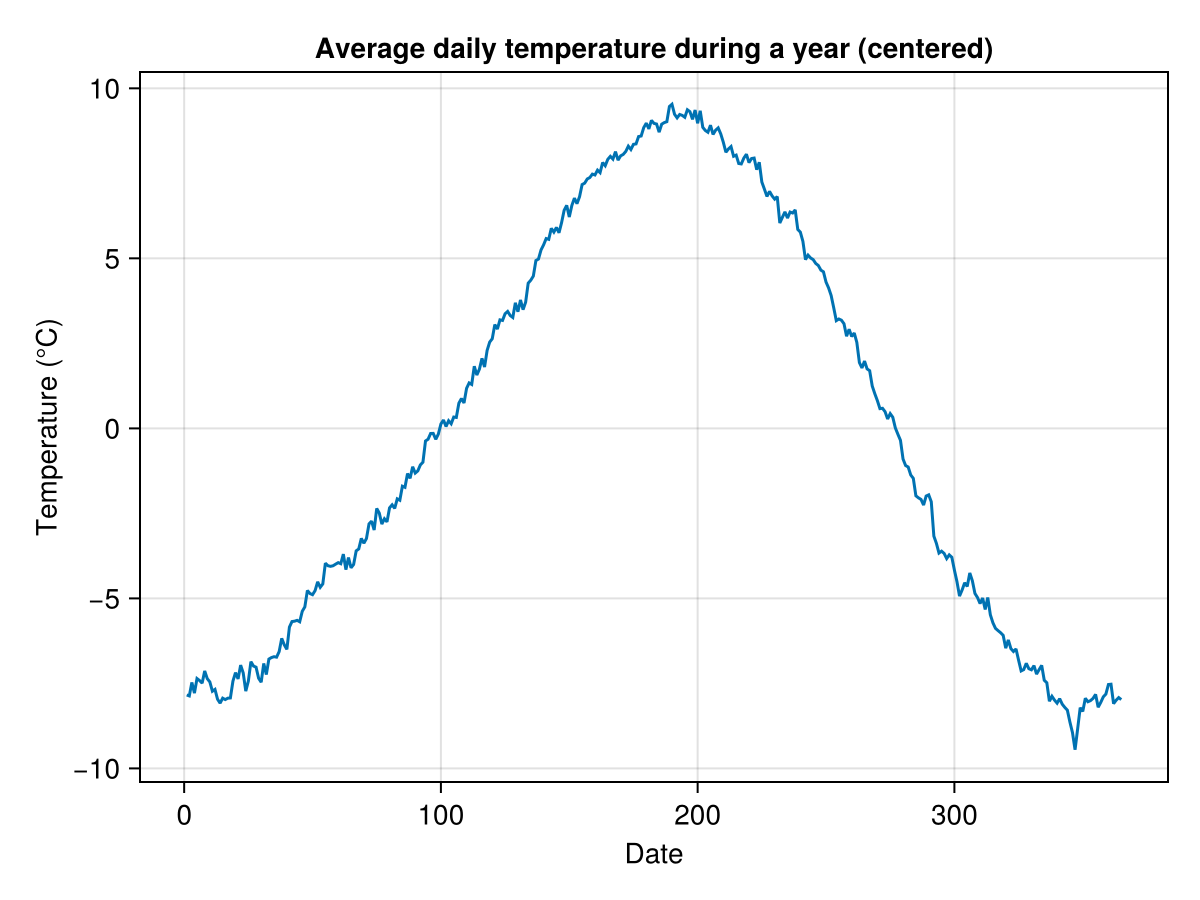

In [135]:
fig, ax = lines(1:365, average_period)
ax.title="Average daily temperature during a year (centered)"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

In [136]:
repeated_period=append!(repeat(average_period,outer=k),average_period[1:N % 365])
filtered_series=undrifted_series-repeated_period

38758-element Vector{Float64}:
  0.07483372759799867
  0.8024527752170441
  1.106262299026568
 -1.379451986687716
  1.9919765847408577
 -0.349928177163906
  3.6272146799789526
  2.8681670609313343
  2.6948337275980006
  3.8910242037884757
  ⋮
  2.687233107054826
  0.718661678483397
 -0.9632430834213661
 -1.3070526072308875
  0.3367569165786324
  3.538661678483394
  3.9415188213405354
  2.140566440388157
  2.7843759641976815

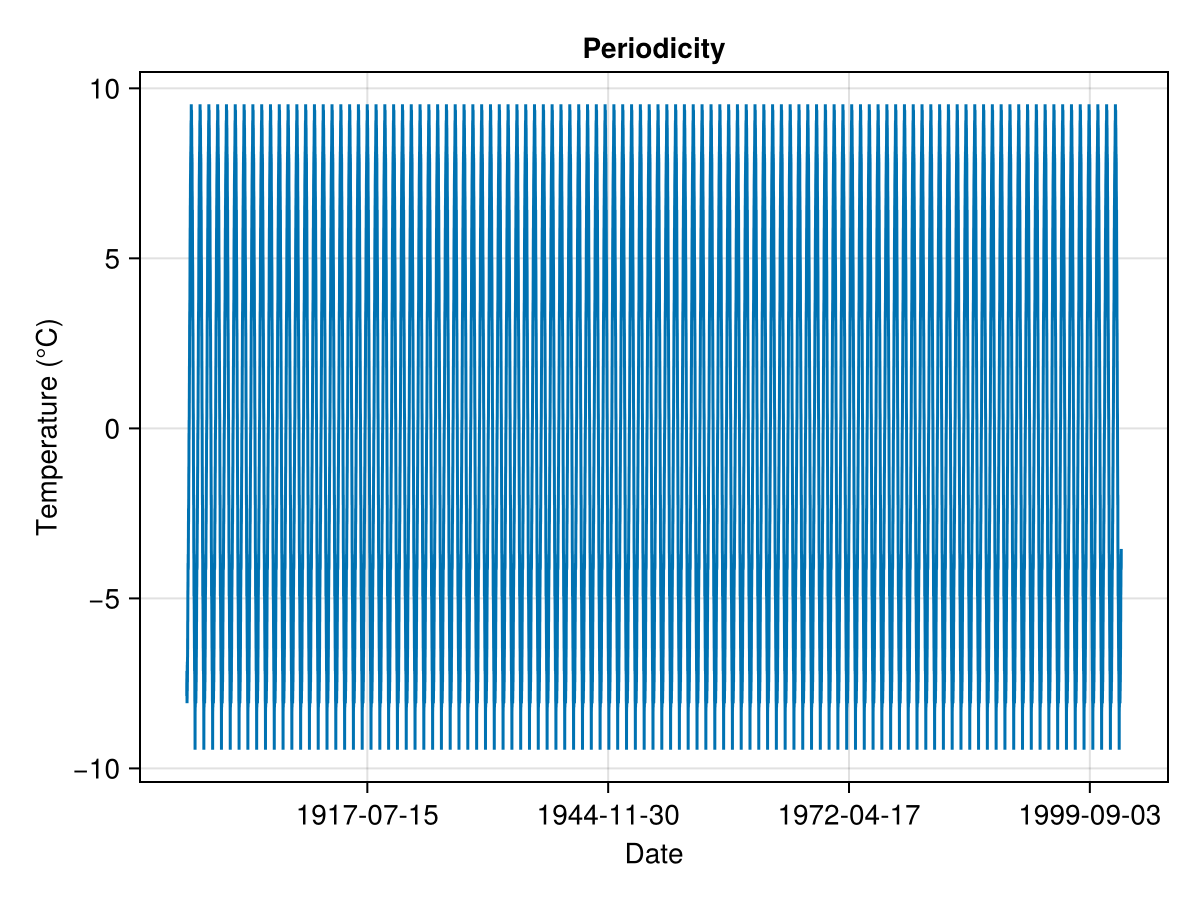

In [137]:
fig, ax = lines(series.DATE, repeated_period)
ax.title="Periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

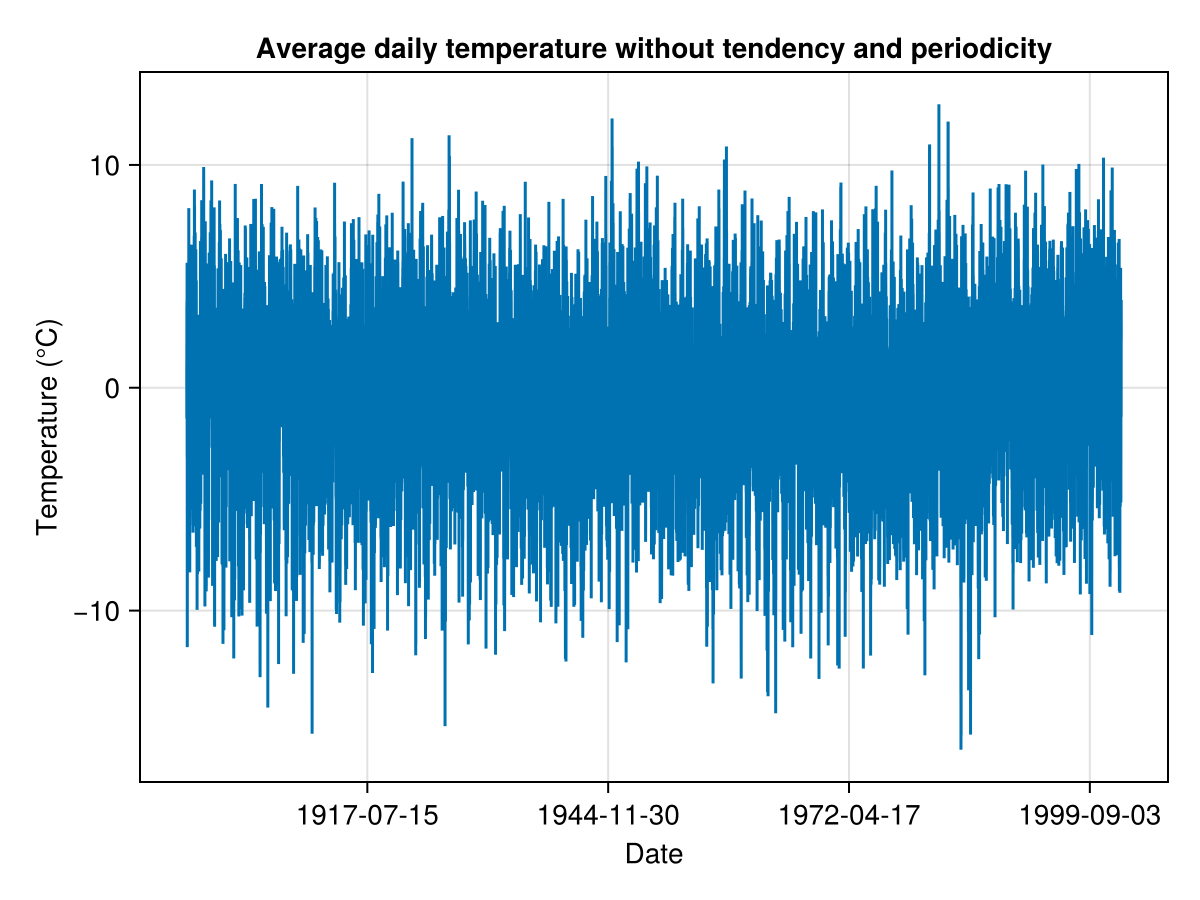

In [138]:
fig, ax = lines(series.DATE, filtered_series)
ax.title="Average daily temperature without tendency and periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

Exemple in 1965

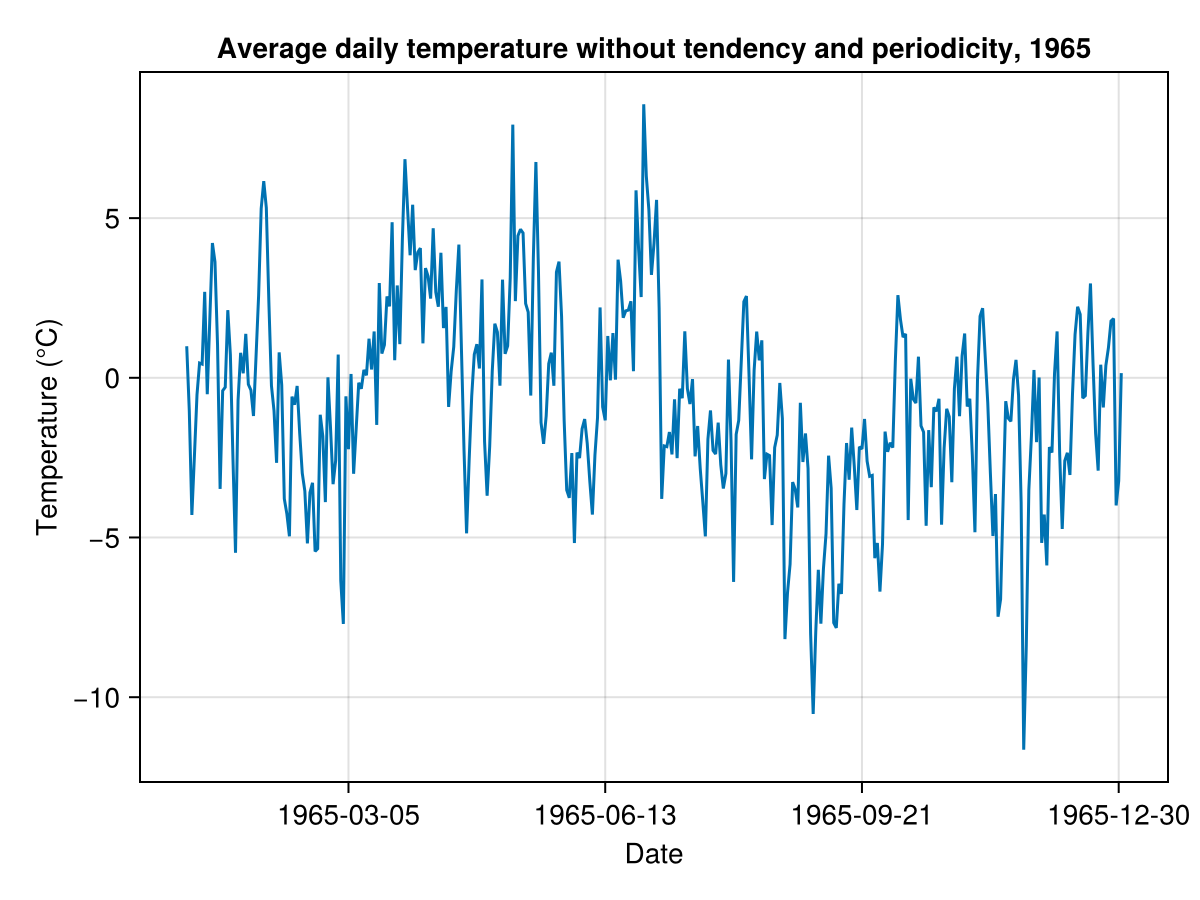

In [139]:
fig, ax = lines(series.DATE[Iyear(series.DATE,1965)], filtered_series[Iyear(series.DATE,1965)])
ax.title="Average daily temperature without tendency and periodicity, 1965"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Autocorrelations

With the package StatsBase

In [140]:
using StatsBase

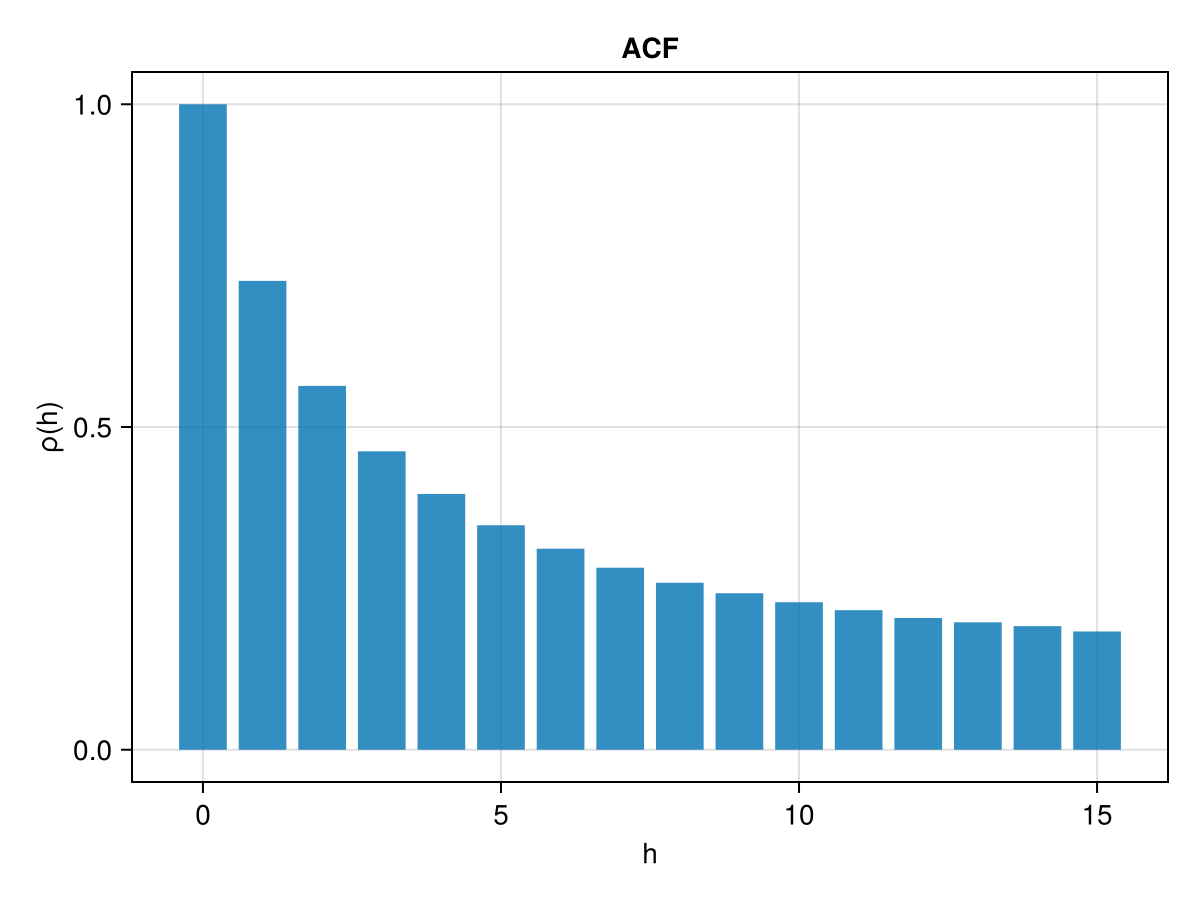

In [141]:
fig, ax = barplot(0:15, autocor(filtered_series,0:15))
ax.title="ACF"
ax.xlabel="h"
ax.ylabel="ρ(h)"
current_figure()

### PACF

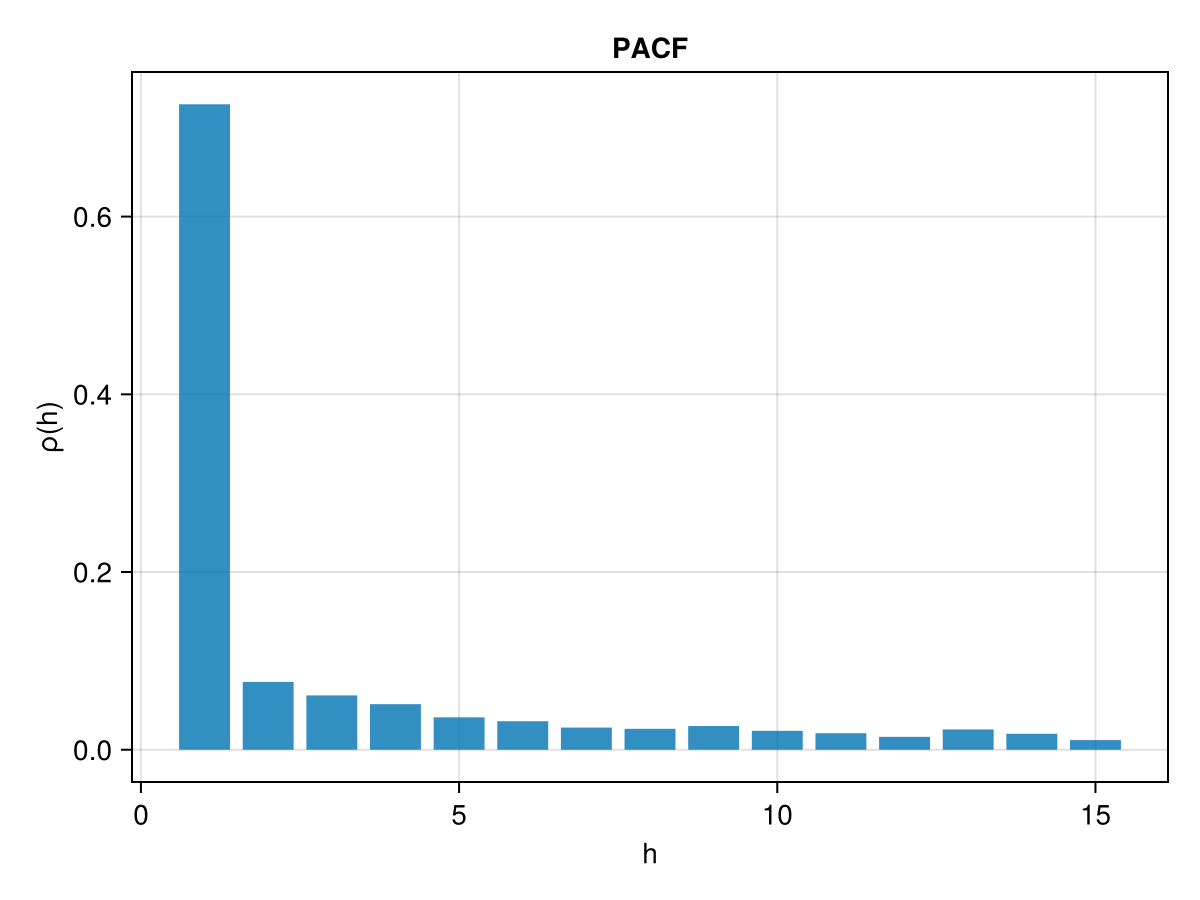

In [142]:
fig, ax = barplot(1:15, pacf(filtered_series,1:15))
ax.title="PACF"
ax.xlabel="h"
ax.ylabel="ρ(h)"
current_figure()

It looks like an AR(1) model

## Estimation with Likelyhood

In [143]:
p=1
opt=LL_AR_Estimation(x,p)
Φ, σ=opt[1] ,opt[2]^0.5

([0.7264053127376335], 2.2012207397865913)

## Prediction "on the past" 

In [144]:
pred=[dot(Φ,x[(t-1):-1:(t-p)]) for t in (p+1):length(x)]  #+σ*randn(length(x)-1)

38757-element Vector{Float64}:
  0.0543596172991471
  0.5829059591387188
  0.8035948112942476
 -1.00204125179644
  1.4469823740047258
 -0.2541896869684572
  2.6348280139766462
  2.083451790879605
  1.9575415366717484
  2.8264606536226693
  ⋮
  1.1847980323614307
  1.9520204055290835
  0.5220396613112847
 -0.6997048932550599
 -0.9494499579200921
  0.24462201330386263
  2.5705026432314093
  2.8631402120771403
  1.554918834565842

In [145]:
try
    using LaTeXStrings
catch ; 
    import Pkg
    Pkg.add("LaTeXStrings")
    using LaTeXStrings
end

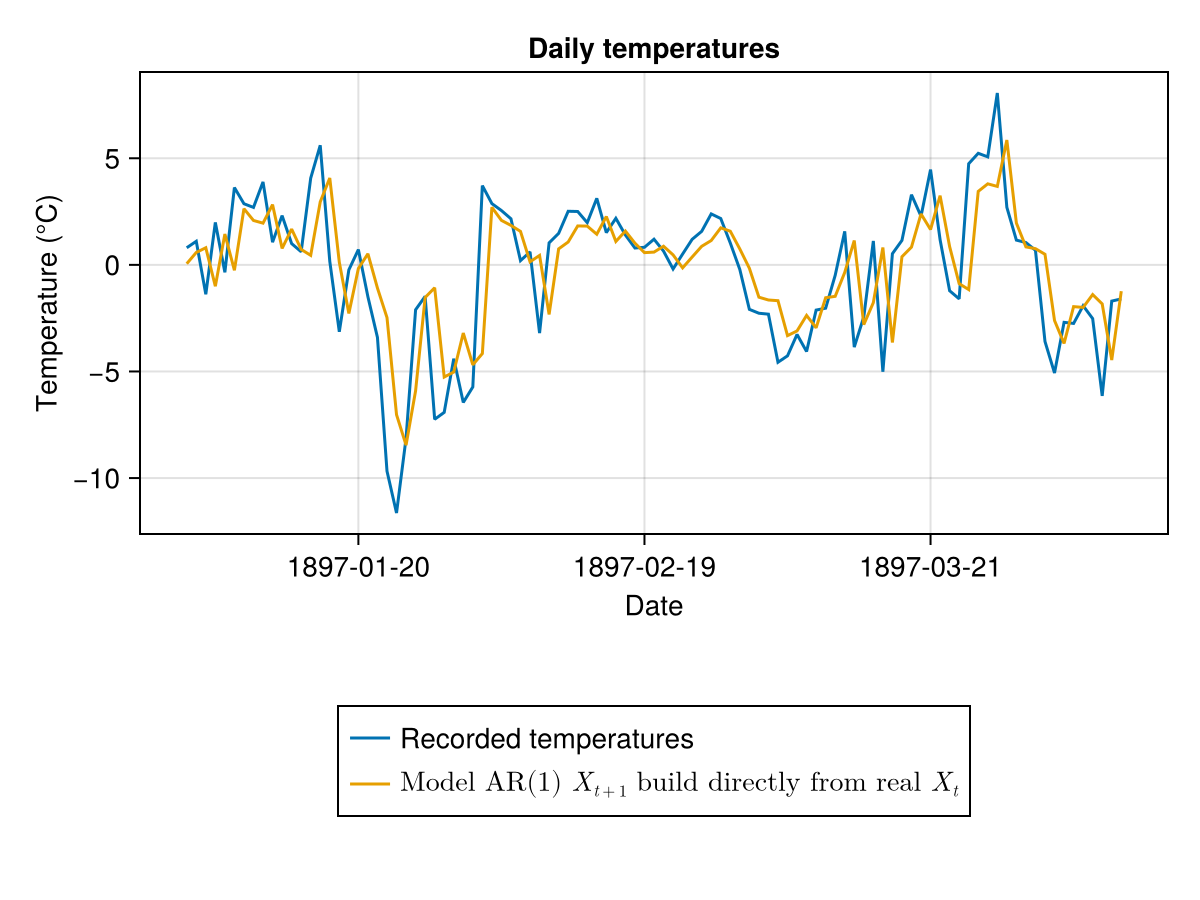

In [146]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[2:100], x[2:100])
plot2=lines!(ax,series.DATE[2:100],pred[1:99])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures",L"Model AR(1) $X_{t+1}$ build directly from real $X_t$"])
current_figure()

## Forecasting

In [147]:
function forecast(x::Number,Φ,n)
    #Forecast the model for n days
    prev = [x * Φ]
    if n > 1 
        for _ in 2:n
            append!(prev, prev[end] * Φ)
        end
    end
    return prev
end

forecast (generic function with 1 method)

In [148]:
prev=forecast(x[end],Φ[1],365*2)

730-element Vector{Float64}:
 2.022585493052167
 1.46921684761916
 1.067246923674196
 0.7752538353598316
 0.5631485047256083
 0.4090740656929362
 0.29715357462253256
 0.2158539353047865
 0.15679744538072235
 0.11389849734824563
 ⋮
 1.6442748908218822e-100
 1.1944100162941076e-100
 8.676257814230832e-101
 6.302479770938684e-101
 4.578154789031324e-101
 3.325595961287594e-101
 2.4157305742981256e-101
 1.754799523312893e-101
 1.2746956965239523e-101

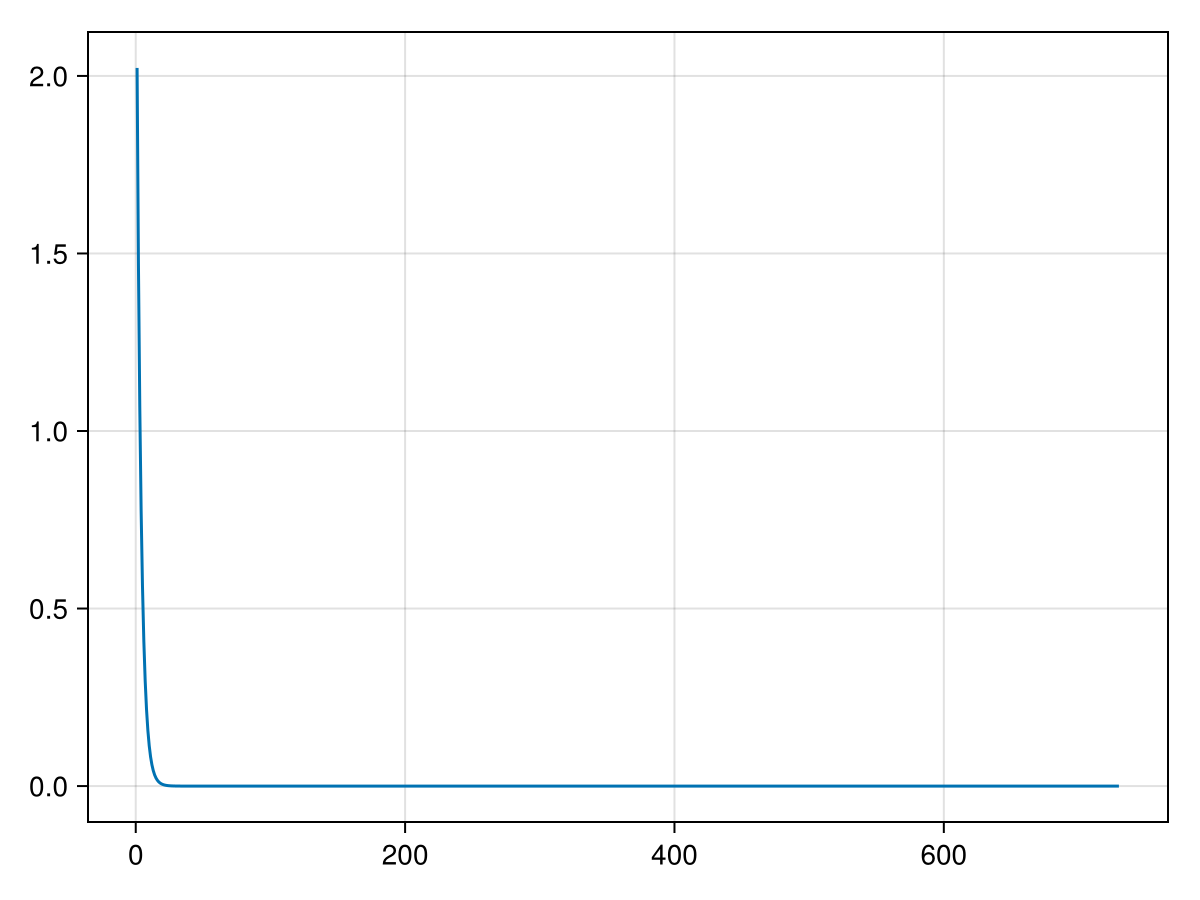

In [149]:
fig,ax,plot1=lines(1:(365*2),prev)

In [150]:
new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*2))

Date("2003-03-31"):Day(1):Date("2005-03-30")

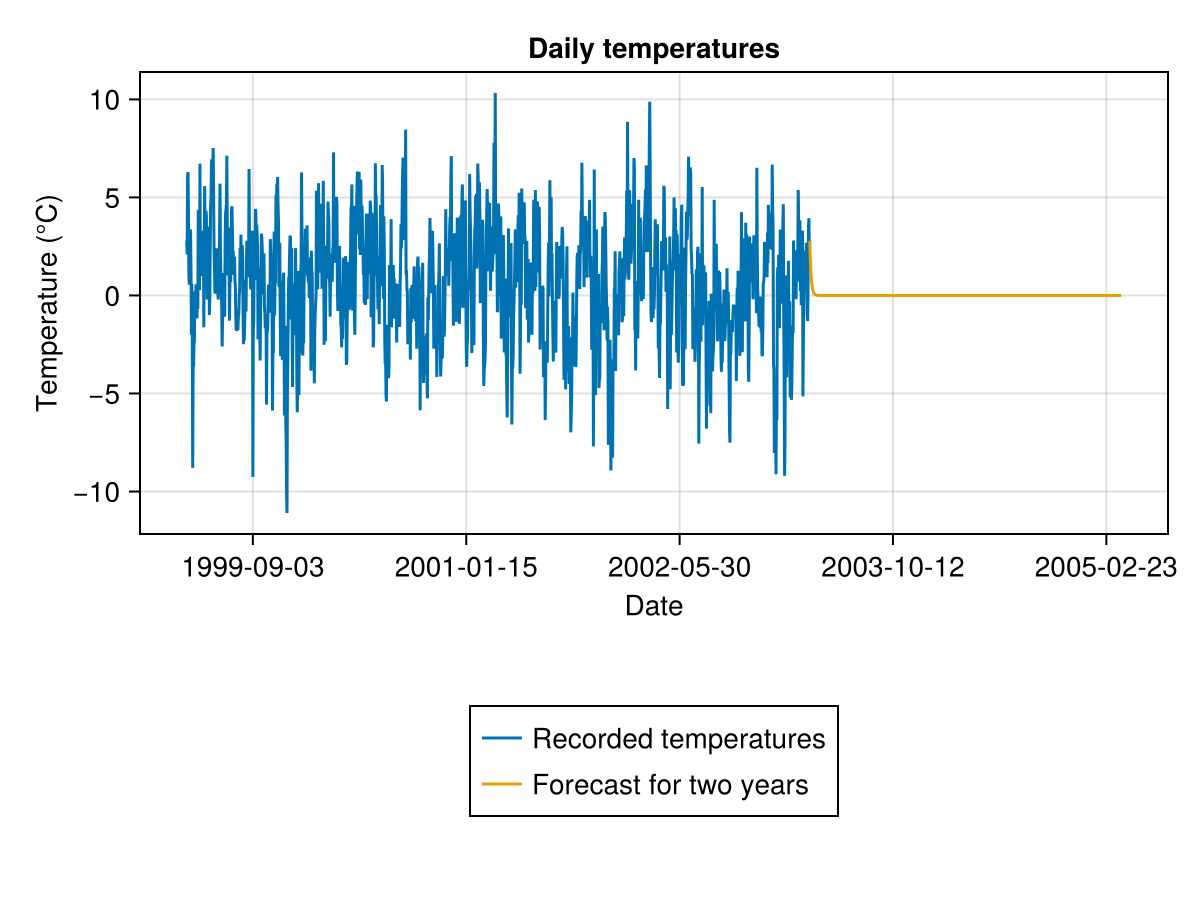

In [151]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Forecast for two years"])
current_figure()

It is not very realistic.

## Simulation

In [152]:
noised_prev=simulation(x[(end-p+1):end],Φ,σ,365*2)

730-element Vector{Float64}:
  3.7866680570959352
  1.3099256613934898
  2.636417684313659
  0.13635842388869346
 -0.7867964241956964
  2.6665443401642013
  4.634518205877233
  2.5680037393558584
 -4.333035391065163
 -4.481195035908921
  ⋮
 -1.7860860739517919
 -1.2792505057123558
  0.5510864949017678
 -2.198786091184522
 -0.5815711583402754
 -4.702776238110696
 -2.4489848206646276
 -1.2852601819774598
  0.045206750559623976

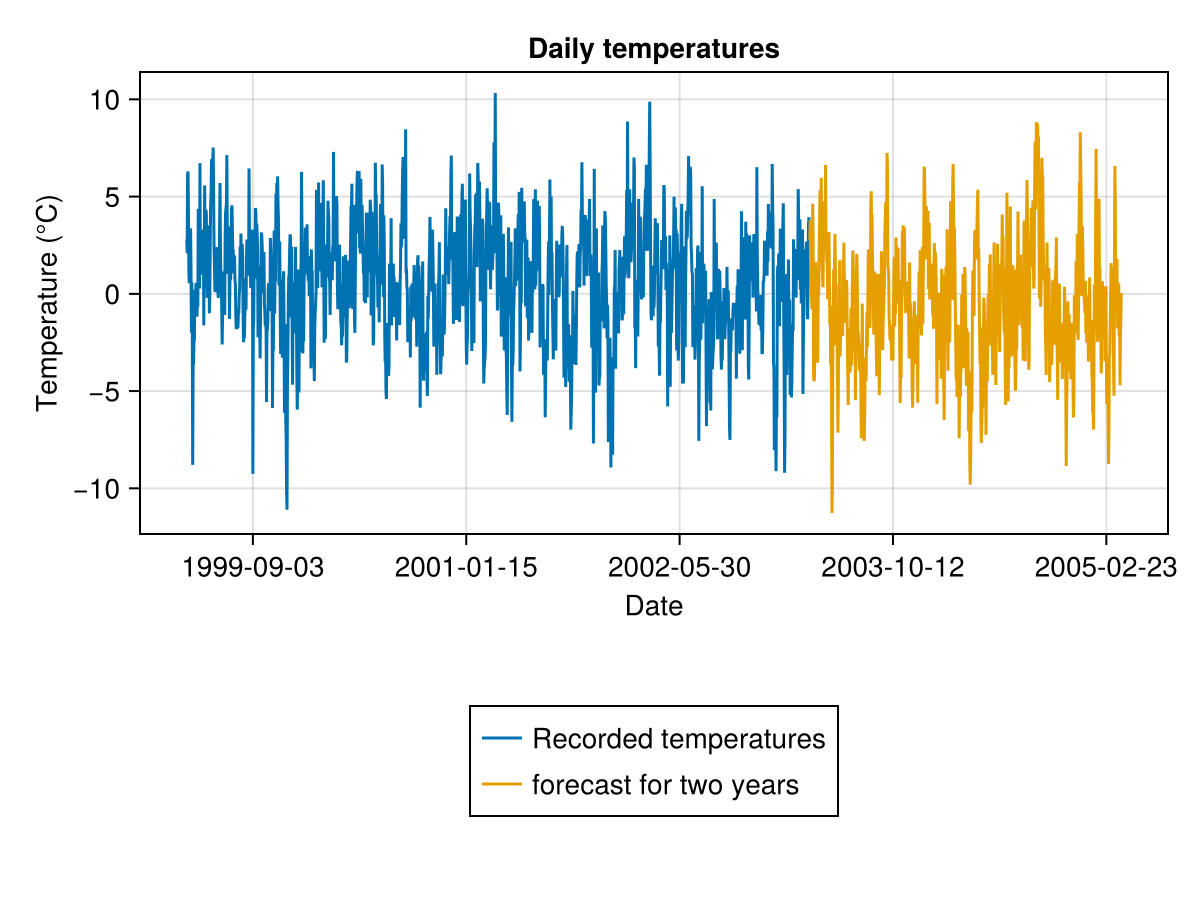

In [153]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;noised_prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","forecast for two years"])
current_figure()

In [154]:
noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],2) .+ beta[1]

730-element Vector{Float64}:
 19.916843777861402
 17.298186405220125
 18.76276345120146
 16.693170166218618
 15.850005103100159
 19.043335652425988
 21.645585017390662
 19.44191747869236
 12.218010990380126
 12.226031606692775
  ⋮
 13.63084824878697
 14.106245030563764
 16.21847657804858
 13.012403300737743
 14.9857984947384
 10.562678438029145
 12.913602497584003
 14.478269302189481
 15.864916495882973

In [155]:
function plot_simulation(n_future_period=2,n_old_period::Int=0) #Use global variables
    new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*n_future_period))
    noised_prev=simulation(x[(end-p+1):end],Φ,σ,365*n_future_period)
    noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],n_future_period) .+ beta[1]
    fig=Figure()
    if n_old_period==0
        ax, plot1=lines(fig[1:2, 1:2], series.DATE, series.TX)
    else
        ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*n_old_period:end], series.TX[end-365*n_old_period:end])
    end
    plot2=lines!(ax,new_date_range,[series.TX[end] ;noised_prev_pm])
    ax.title="Daily temperatures"
    ax.xlabel="Date"
    ax.ylabel="Temperature (°C)"
    Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Simulation for $(n_future_period) years"])
    return fig
end

plot_simulation (generic function with 3 methods)

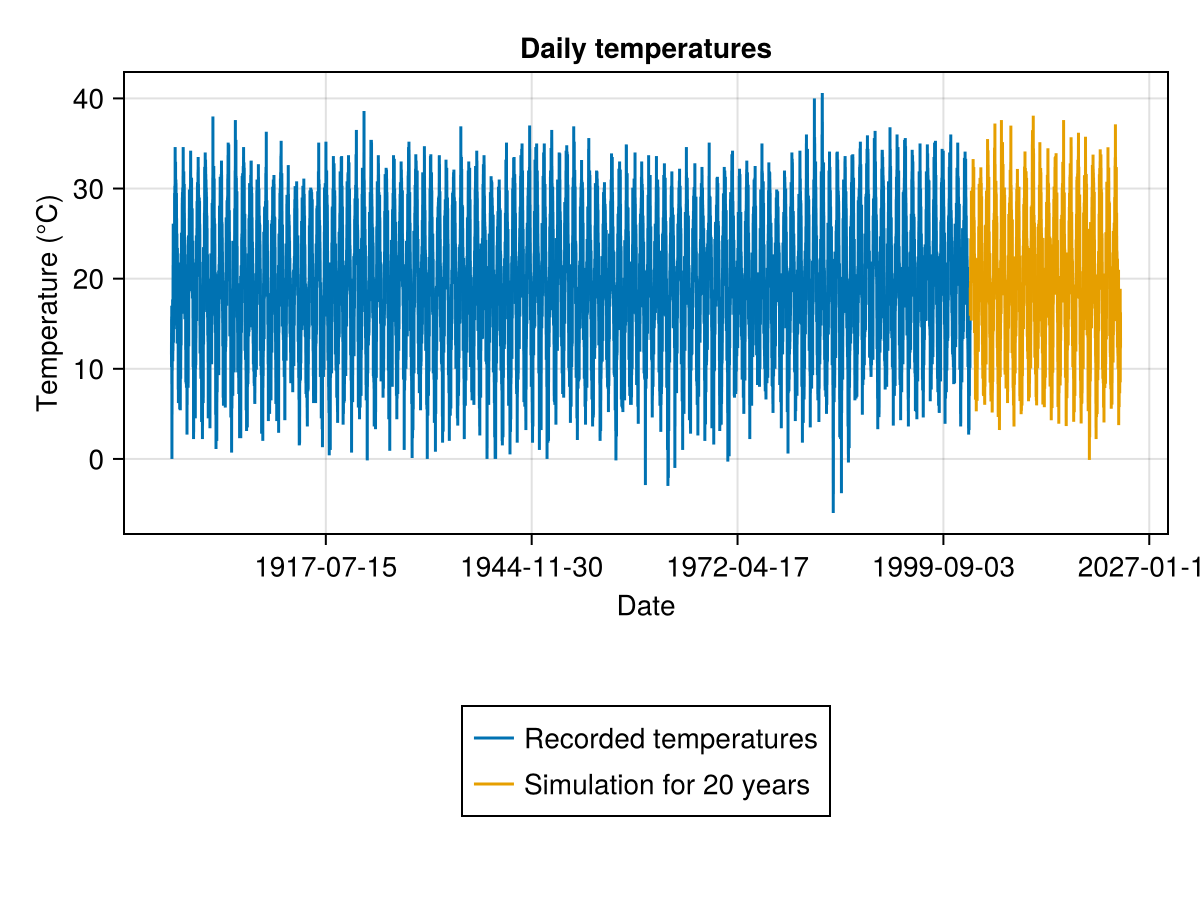

In [156]:
plot_simulation(20)

## Sampling simulations

In [157]:
Φ

1-element Vector{Float64}:
 0.7264053127376335

In [158]:
repeated_period

38758-element Vector{Float64}:
 -7.840852999024626
 -7.86848226167774
 -7.472302000521335
 -7.786597929841122
 -7.358036716303765
 -7.416142169433068
 -7.493295241609997
 -7.134257837596449
 -7.360934719297186
 -7.45713541052173
  ⋮
 -3.9490747336537946
 -3.980513520116436
 -3.6986189732457433
 -4.154819664470291
 -3.798639403313881
 -4.1005543802527145
 -4.003421738143926
 -3.602479572225616
 -3.546299311069208

In [159]:
[[5.]]

1-element Vector{Vector{Float64}}:
 [5.0]

In [160]:
include("utils.jl")
sample_=invert(sample_simulation(x[1:p],Φ,σ,repeated_period,105,5))

365-element Vector{Vector{Float64}}:
 [-0.09501642201623017, -2.5364198011461445, -10.28703392302788, -9.44799981322948, -3.2847304205673193, -3.4473471424887263, -2.4285633127031225, -13.670967373140373, -8.235270567511456, -7.720226799134977  …  -11.521305899775108, -12.093325512128917, -10.03534377457623, -7.323498751484102, -4.528603674791647, -2.06818158199442, -6.9237917302446395, -7.0539542988263095, -6.3095185922829575, -5.952063751453774]
 [0.9032972350974715, -3.104559613976618, -11.492984960140461, -10.861016063822426, -5.653456022646846, -3.0239374202691653, -3.78561598350837, -12.92743334584587, -12.110063130995432, -6.767963512157172  …  -10.598708794576087, -8.969025193608399, -7.12874172315925, -12.506268340804347, -5.427487165402491, -1.8569563569799357, -8.619422582759817, -7.567644934175727, -7.498989279313854, -7.3615273604025235]
 [0.07637715623604002, -3.183391147975609, -14.469655754020014, -10.114821043684696, -4.162653929434038, -2.9228151217414373, 0.058912592

To apply statistical functions on each days, the sample vector will be inverted (it was shaped like v[year][day], no it is shaped like v[day][year]).

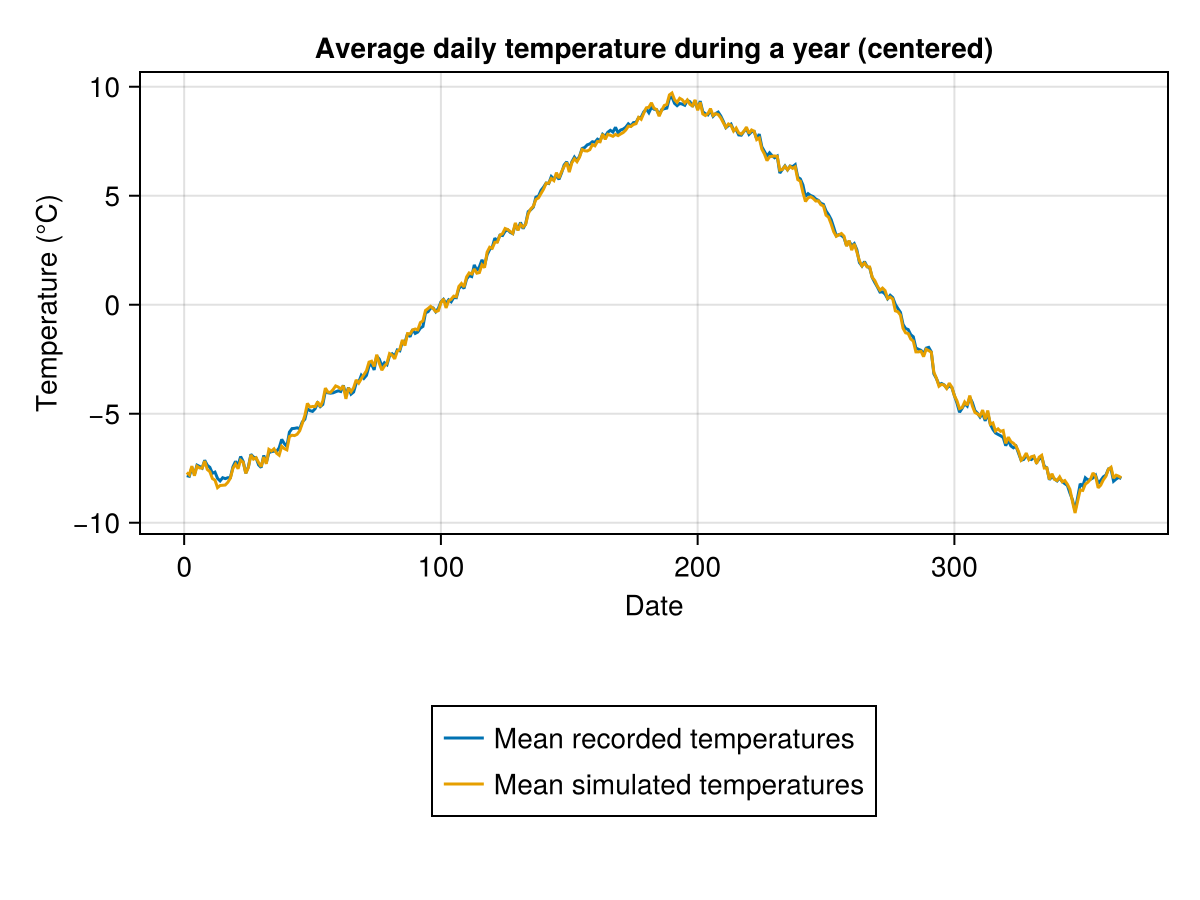

In [161]:
fig=Figure()
ax, plot1 = lines(fig[1:2,1:2], 1:365, average_period)
plot2=lines!(ax,1:365,mean.(sample_))
ax.title="Average daily temperature during a year (centered)"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Mean recorded temperatures","Mean simulated temperatures"])
current_figure()

The generated sample seems to be unbiased.

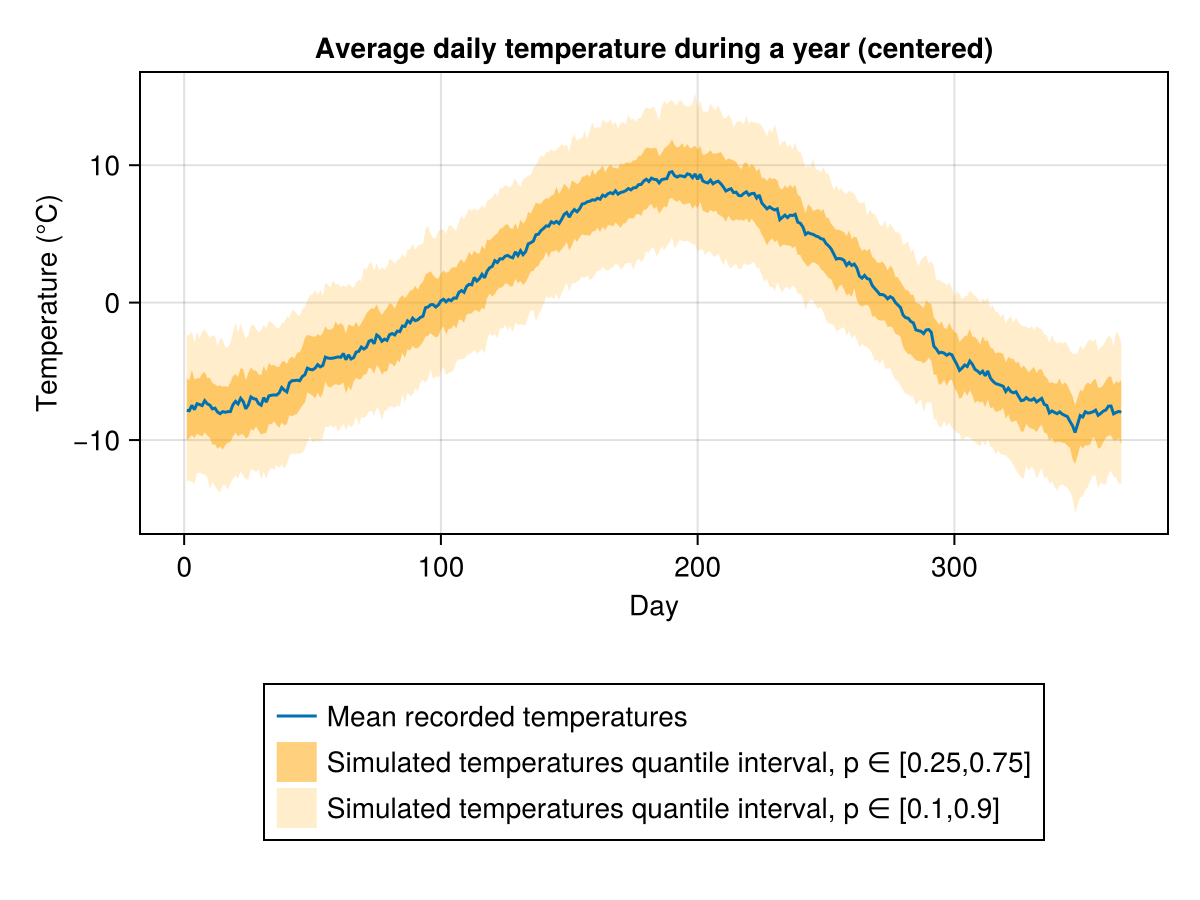

In [162]:
fig=Figure()
ax, plot1 = band(fig[1:2,1:2],1:365,quantile.(sample_,0.05),quantile.(sample_,0.95) ; color=("orange",0.2))
plot2=band!(ax,1:365,quantile.(sample_,0.25),quantile.(sample_,0.75) ; color=("orange",0.5))
plot3=lines!(ax, 1:365, average_period)
ax.title="Average daily temperature during a year (centered)"
ax.xlabel="Day"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot3,plot2,plot1],["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.25,0.75]","Simulated temperatures quantile interval, p ∈ [0.1,0.9]"])
current_figure()